# Imports and Settings

In [80]:
import pandas as pd
import os
from typing import List
from typing import Optional
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [25]:
# Создаём внутренние папки проекта
folders = ['prepared_data', 'catboost_models']

for folder in folders:
    os.makedirs(folder, exist_ok=True) 

In [2]:
# Настройка pandas 
# Показывать все столбцы
pd.set_option('display.max_columns', None)
# Отображать полный текст в ячейках столбцов без усечения
pd.set_option('display.max_colwidth', None)

# Functions

## Functions for assembling a dataset from parquet files

In [3]:
def read_parquet_dataset_from_local(
    path_to_dataset: str,
    start_from: int = 0,
    num_parts_to_read: int = 2,
    columns: Optional[List[str]] = None,
    verbose: bool = False
) -> pd.DataFrame:
    """
    Читает num_parts_to_read партиций, преобразовывает их к pd.DataFrame и возвращает.

    :param path_to_dataset: путь до директории с партициями
    :param start_from: номер партиции, с которой нужно начать чтение
    :param num_parts_to_read: количество партиций, которые требуется прочитать
    :param columns: список колонок, которые нужно прочитать из партиции
    :param verbose: выводить ли дополнительную информацию
    :return: pd.DataFrame
    """
    res = []
    dataset_paths = sorted(
        os.path.join(path_to_dataset, filename)
        for filename in os.listdir(path_to_dataset)
        if filename.startswith('train')
    )

    if verbose:
        print('Dataset paths:')
        for path in dataset_paths:
            print(path)

    start_from = max(0, start_from)
    chunks = dataset_paths[start_from: start_from + num_parts_to_read]

    if verbose:
        print('Reading chunks:')
        for chunk in chunks:
            print(chunk)

    for chunk_path in tqdm(chunks, desc="Reading dataset with pandas"):
        if verbose:
            print('Reading chunk:', chunk_path)
        chunk = pd.read_parquet(chunk_path, columns=columns)
        res.append(chunk)

    return pd.concat(res).reset_index(drop=True)

In [4]:
def prepare_transactions_dataset(
    path_to_dataset: str,
    num_parts_to_preprocess_at_once: int = 1,
    num_parts_total: int = 50,
    save_to_path: str = None,
    verbose: bool = False
) -> pd.DataFrame:
    """
    Возвращает исходный pd.DataFrame с признаками из которых нужно собрать
    учебный датасет.

    :param path_to_dataset:
        путь до датасета с партициями
    :param num_parts_to_preprocess_at_once:
        количество партиций, которые будут одновременно держаться и обрабатываться в памяти
    :param num_parts_total:
        общее количество партиций, которые нужно обработать
    :param save_to_path: 
        путь до папки для сохранения обработанных блоков в .parquet-формате; если None, сохранение не происходит
    :param verbose: 
        логировать каждую обрабатываемую часть данных
    :return: pd.DataFrame с объединёнными данными
    """
    preprocessed_frames = []

    for step in tqdm(range(0, num_parts_total, num_parts_to_preprocess_at_once),
                     desc="Transforming transactions data"):
        transactions_frame = read_parquet_dataset_from_local(
            path_to_dataset,
            start_from=step,
            num_parts_to_read=num_parts_to_preprocess_at_once,
            verbose=verbose
        )

       # Записываем подготовленные данные в файл
        if save_to_path:
            block_as_str = str(step)
            if len(block_as_str) == 1:
                block_as_str = '00' + block_as_str
            else:
                block_as_str = '0' + block_as_str
            transactions_frame.to_parquet(os.path.join(save_to_path, f'processed_chunk_{block_as_str}.parquet'))

        preprocessed_frames.append(transactions_frame)
    
    return pd.concat(preprocessed_frames)

## Feature engineering functions

In [47]:
def create_rn_count_feature(
    df_source: pd.DataFrame, 
    df_to_update: pd.DataFrame
) -> pd.DataFrame:
    """
    Добавляет в df_to_update новую колонку 'rn_count', 
    содержащую максимальное значение 'rn' для каждого 'id' из df_source.

    Параметры:
    df_source (pd.DataFrame): исходный DataFrame с колонками 'id' и 'rn'.
    df_to_update (pd.DataFrame): DataFrame, в который добавляется новая колонка.

    Возвращает:
    pd.DataFrame: обновлённый df_to_update с колонкой 'rn_count'.
    """
    df_to_update['rn_count'] = df_source.groupby('id')['rn'].max()
    return df_to_update

# Description of dataset

In [3]:
# Описание признаков датасета
df_schema = pd.read_excel('description.xlsx', sheet_name='features')
df_schema

,Поле,Описание
0,id,"Идентификатор заявки. Заявки пронумерованы так, что большему номеру соответствует более поздняя дата заявки."
1,rn,Порядковый номер кредитного продукта в кредитной истории. Большему номеру соответствует продукт с более поздней датой открытия.
2,pre_since_opened,Дней с даты открытия кредита до даты сбора данных (бинаризовано*)
3,pre_since_confirmed,Дней с даты подтверждения информации по кредиту до даты сбора данных (бинаризовано*)
4,pre_pterm,Плановое количество дней с даты открытия кредита до даты закрытия (бинаризовано*)
5,pre_fterm,Фактическое количество дней с даты открытия кредита до даты закрытия (бинаризовано*)
6,pre_till_pclose,Плановое количество дней с даты сбора данных до даты закрытия кредита (бинаризовано*)
7,pre_till_fclose,Фактическое количество дней с даты сбора данных до даты закрытия кредита (бинаризовано*)
8,pre_loans_credit_limit,Кредитный лимит (бинаризовано*)
9,pre_loans_next_pay_summ,Сумма следующего платежа по кредиту (бинаризовано*)


# Target

In [30]:
# Загрузим датасет с целевой переменной
df_target = pd.read_csv('train_target.csv')
df_target

,id,flag
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
2999995,2999995,0
2999996,2999996,0
2999997,2999997,0
2999998,2999998,0


In [12]:
# Проверим на пустые значения
print('Количество пустых строк',
df_target[df_target.isnull().any(axis=1)].shape[0])

Количество пустых строк 0


In [13]:
# Проверим на дубликаты строк
print('Количество дубликатов строк',
df_target[df_target.duplicated()].shape[0])

Количество дубликатов строк 0


In [14]:
df_target.dtypes

id      int64
flag    int64
dtype: object

In [15]:
# Проверим на монотонное возрастание id
print('id возростает монотонно',
df_target['id'].is_monotonic_increasing)

id возростает монотонно True


In [16]:
# Вычислим коэффициент дисбаланса
print('Коэффициент дисбаланса', 
df_target[df_target.flag == 0].shape[0] / df_target[df_target.flag == 1].shape[0])

Коэффициент дисбаланса 27.18436331523271


Выводы.    
Дубликатов и пустых значений нет, типы данных правильные, id идёт по порядку возрастания.  
Датасет перекошен в 27 раз сторону класса 0.

# Assemble the source dataset from parquet files

In [5]:
# Путь до исходных данных на компьютере
path = 'train_data/'

In [6]:
# Исходный данные находятся в двенадцати файлах parquet
df = prepare_transactions_dataset(
    path,
    num_parts_to_preprocess_at_once=1,
    num_parts_total=12,
    save_to_path='train_data/')

Transforming transactions data:   0%|          | 0/12 [00:00<?, ?it/s]

Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
df

,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,pre_loans_outstanding,pre_loans_total_overdue,pre_loans_max_overdue_sum,pre_loans_credit_cost_rate,pre_loans5,pre_loans530,pre_loans3060,pre_loans6090,pre_loans90,is_zero_loans5,is_zero_loans530,is_zero_loans3060,is_zero_loans6090,is_zero_loans90,pre_util,pre_over2limit,pre_maxover2limit,is_zero_util,is_zero_over2limit,is_zero_maxover2limit,enc_paym_0,enc_paym_1,enc_paym_2,enc_paym_3,enc_paym_4,enc_paym_5,enc_paym_6,enc_paym_7,enc_paym_8,enc_paym_9,enc_paym_10,enc_paym_11,enc_paym_12,enc_paym_13,enc_paym_14,enc_paym_15,enc_paym_16,enc_paym_17,enc_paym_18,enc_paym_19,enc_paym_20,enc_paym_21,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag
0,0,1,18,9,2,3,16,10,11,3,3,0,2,11,6,16,5,4,8,1,1,1,1,1,16,2,17,1,1,1,0,0,3,3,3,3,3,3,3,3,3,4,3,3,3,3,3,3,3,3,4,3,3,3,4,1,3,4,1,0,0
1,0,2,18,9,14,14,12,12,0,3,3,0,2,11,6,16,5,4,8,1,1,1,1,1,16,2,17,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,4,1,3,4,1,0,0
2,0,3,18,9,4,8,1,11,11,0,5,0,2,8,6,16,5,4,8,1,1,1,1,1,15,2,17,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,4,1,2,3,1,1,1
3,0,4,4,1,9,12,16,7,12,2,3,0,2,4,6,16,5,4,8,0,1,1,1,1,16,2,17,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,3,3,3,3,3,3,3,3,4,3,3,3,4,1,3,1,1,0,0
4,0,5,5,12,15,2,11,12,10,2,3,0,2,4,6,16,5,4,8,1,1,1,1,1,16,2,17,1,1,1,0,0,0,0,0,0,0,3,3,3,3,4,3,3,3,3,3,3,3,3,4,3,3,3,4,1,3,4,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2284251,2499999,11,3,9,4,3,1,12,6,2,3,0,2,7,6,16,5,4,8,1,1,1,1,1,16,2,17,1,1,1,0,0,3,3,3,3,3,3,3,3,3,4,3,3,3,3,3,3,3,3,4,3,3,3,4,1,3,4,1,1,0
2284252,2499999,12,3,9,1,15,12,6,9,3,3,0,2,11,6,16,5,4,8,1,1,1,1,1,16,2,17,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,3,4,3,3,3,4,1,3,4,1,0,0
2284253,2499999,13,2,9,4,8,1,11,7,3,5,0,1,5,6,16,5,4,8,1,0,1,1,1,1,2,3,0,1,0,0,0,0,0,0,0,0,1,0,0,0,2,1,1,1,0,3,3,3,3,4,3,3,3,4,1,2,3,1,1,1
2284254,2499999,14,2,9,4,9,1,15,16,2,3,0,1,2,6,16,5,4,8,1,0,1,1,1,16,2,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,3,3,3,3,3,3,3,4,3,3,3,4,1,3,4,1,1,0


In [13]:
print('Количество уникальных id',
f'{df.id.nunique():,}')

Количество уникальных id 3,000,000


In [14]:
# Проверим на пустые значения
print('Количество пустых строк',
df[df.isnull().any(axis=1)].shape[0])

Количество пустых строк 0


In [15]:
# Проверим на дубликаты строк
print('Количество дубликатов строк',
df[df.duplicated()].shape[0])

Количество дубликатов строк 0


In [22]:
df.dtypes.tolist()

[dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'

In [18]:
# Проверим на монотонное возрастание id
print('id возростает монотонно',
df['id'].is_monotonic_increasing)

id возростает монотонно False


In [19]:
# Пусть id и rn идут по возрастанию
df.sort_values(by=['id', 'rn'], ignore_index=True, inplace=True)

print('id возростает монотонно',
df['id'].is_monotonic_increasing)

id возростает монотонно True


In [21]:
# Проверим на монотонное возрастание и уникальность индексов
print('Индекс возрастает монотонно', 
df.index.is_monotonic_increasing)

print('Индексы уникальны',
df.index.is_unique)

Индекс возрастает монотонно True
Индексы уникальны True


In [26]:
# Запишем исходный датасет в файл
df.to_csv('prepared_data/source_data.csv', index=False)

# Create train/test datasets, split sourse dataset

Разделим таргет датасет на тренировочную и тестовую часть и создадим df_train/df_test,    
датасет с исходными данными поделим на source_df_train/source_df_test     
соответсвенно id в df_train/df_test.    
В df_train/df_test будем набирать фичи через агрегирование признаков в source_df_train/source_df_test.

In [37]:
# Разделим  таргет датасет на тренировочную и тестовую подвыборки
df_train, df_test  = train_test_split(
    df_target,
    train_size=0.8,
    random_state=0,
    stratify=df_target.flag
)
df_train.shape, df_test.shape

((2400000, 2), (600000, 2))

In [39]:
# Отсортируем результат по id
df_train = df_train.sort_values(by='id').reset_index(drop=True)
df_test = df_test.sort_values(by='id').reset_index(drop=True)

In [41]:
# Выберем id из тренировочной и тестовой подвыборок
train_id = df_train['id'].values
test_id = df_test['id'].values

In [42]:
# Разделим исходный датасет по id на тренировочную и тестовую подвыборки 
source_df_train = df[df['id'].isin(train_id)]
source_df_test = df[df['id'].isin(test_id)]
source_df_train.shape, source_df_test.shape

((20931476, 61), (5231241, 61))

In [43]:
df_train.head(3)

,id,flag
0,0,0
1,1,0
2,2,0


In [44]:
source_df_train.head(3)

,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,pre_loans_outstanding,pre_loans_total_overdue,pre_loans_max_overdue_sum,pre_loans_credit_cost_rate,pre_loans5,pre_loans530,pre_loans3060,pre_loans6090,pre_loans90,is_zero_loans5,is_zero_loans530,is_zero_loans3060,is_zero_loans6090,is_zero_loans90,pre_util,pre_over2limit,pre_maxover2limit,is_zero_util,is_zero_over2limit,is_zero_maxover2limit,enc_paym_0,enc_paym_1,enc_paym_2,enc_paym_3,enc_paym_4,enc_paym_5,enc_paym_6,enc_paym_7,enc_paym_8,enc_paym_9,enc_paym_10,enc_paym_11,enc_paym_12,enc_paym_13,enc_paym_14,enc_paym_15,enc_paym_16,enc_paym_17,enc_paym_18,enc_paym_19,enc_paym_20,enc_paym_21,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag
0,0,1,18,9,2,3,16,10,11,3,3,0,2,11,6,16,5,4,8,1,1,1,1,1,16,2,17,1,1,1,0,0,3,3,3,3,3,3,3,3,3,4,3,3,3,3,3,3,3,3,4,3,3,3,4,1,3,4,1,0,0
1,0,2,18,9,14,14,12,12,0,3,3,0,2,11,6,16,5,4,8,1,1,1,1,1,16,2,17,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,4,1,3,4,1,0,0
2,0,3,18,9,4,8,1,11,11,0,5,0,2,8,6,16,5,4,8,1,1,1,1,1,15,2,17,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,4,1,2,3,1,1,1


In [46]:
# Сохраним тренировочную и тестовую подвыборки таргет датасета
df_train.to_csv('prepared_data/features_data_train.csv', index=False)
df_test.to_csv('prepared_data/features_data_test.csv', index=False)

In [45]:
# Сохраним тренировочную и тестовую подвыборки исходного датасета
source_df_train.to_csv('prepared_data/source_data_train.csv', index=False)
source_df_test.to_csv('prepared_data/source_data_test.csv', index=False)

# Feature engineering

## Lists of feature groups

In [54]:
# Группы признаков

# rn - уникальный признак

# Бинаризированные
pre_features = [
    'pre_since_opened',
    'pre_since_confirmed',
    'pre_pterm',
    'pre_fterm',
    'pre_till_pclose',
    'pre_till_fclose',
    'pre_loans_credit_limit',
    'pre_loans_next_pay_summ',
    'pre_loans_outstanding',
    'pre_loans_total_overdue',
    'pre_loans_max_overdue_sum',
    'pre_loans_credit_cost_rate',
    'pre_loans5',
    'pre_loans530',
    'pre_loans3060',
    'pre_loans6090',
    'pre_loans90',
    'pre_util',
    'pre_over2limit',
    'pre_maxover2limit'
]

# Закодированные
enc_features = [
    'enc_loans_account_holder_type',
    'enc_loans_credit_status',
    'enc_loans_credit_type',
    'enc_loans_account_cur'
]

# Статусы ежемесячных платежей
enc_paym_features = [
    'enc_paym_0',
    'enc_paym_1',
    'enc_paym_2',
    'enc_paym_3',
    'enc_paym_4',
    'enc_paym_5',
    'enc_paym_6',
    'enc_paym_7',
    'enc_paym_8',
    'enc_paym_9',
    'enc_paym_10',
    'enc_paym_11',
    'enc_paym_12',
    'enc_paym_13',
    'enc_paym_14',
    'enc_paym_15',
    'enc_paym_16',
    'enc_paym_17',
    'enc_paym_18',
    'enc_paym_19',
    'enc_paym_20',
    'enc_paym_21',
    'enc_paym_22',
    'enc_paym_23',
    'enc_paym_24'
]

#  Флаги
flags_features = [
    'is_zero_loans5',
    'is_zero_loans530',
    'is_zero_loans3060',
    'is_zero_loans6090',
    'is_zero_loans90',
    'is_zero_util',
    'is_zero_over2limit',
    'is_zero_maxover2limit',
    'pclose_flag',
    'fclose_flag'
]

##  From rn create rn_count feature

Добавим в df_train/df_test новую колонку 'rn_count',    
содержащую максимальное значение 'rn' для каждого 'id' из df_source.

In [51]:
df_train = create_rn_count_feature(source_df_train, df_train)
df_test = create_rn_count_feature(source_df_test, df_test)
df_train.shape, df_test.shape

((2400000, 3), (600000, 3))

In [52]:
# Сохраним промежуточный результат
df_train.to_csv('prepared_data/features_data_train.csv', index=False)
df_test.to_csv('prepared_data/features_data_test.csv', index=False)

## Pre_features

### Research pre_features

In [56]:
df = pd.read_csv('prepared_data/source_data.csv')
df.shape

(26162717, 61)

In [66]:
source_df_train = pd.read_csv('prepared_data/source_data_train.csv')
source_df_train.shape

(20931476, 61)

In [67]:
source_df_test = pd.read_csv('prepared_data/source_data_test.csv')
source_df_test.shape

(5231241, 61)

In [57]:
# Посмотрим на количество уникальных значений признаков
for col in df[pre_features]:
    print(col, df[col].nunique())

pre_since_opened 20
pre_since_confirmed 18
pre_pterm 18
pre_fterm 17
pre_till_pclose 17
pre_till_fclose 16
pre_loans_credit_limit 20
pre_loans_next_pay_summ 7
pre_loans_outstanding 5
pre_loans_total_overdue 2
pre_loans_max_overdue_sum 4
pre_loans_credit_cost_rate 14
pre_loans5 13
pre_loans530 20
pre_loans3060 10
pre_loans6090 5
pre_loans90 7
pre_util 20
pre_over2limit 20
pre_maxover2limit 20


In [58]:
# Посмотрим на признак с двумя значениями
df.pre_loans_total_overdue.value_counts()

pre_loans_total_overdue
0    26162716
1           1
Name: count, dtype: int64

In [59]:
# Удалим его из списка как неинформативный
pre_features.remove('pre_loans_total_overdue')
pre_features

['pre_since_opened',
 'pre_since_confirmed',
 'pre_pterm',
 'pre_fterm',
 'pre_till_pclose',
 'pre_till_fclose',
 'pre_loans_credit_limit',
 'pre_loans_next_pay_summ',
 'pre_loans_outstanding',
 'pre_loans_max_overdue_sum',
 'pre_loans_credit_cost_rate',
 'pre_loans5',
 'pre_loans530',
 'pre_loans3060',
 'pre_loans6090',
 'pre_loans90',
 'pre_util',
 'pre_over2limit',
 'pre_maxover2limit']

In [60]:
# Посмотрим есть ли различия в уникальных значениях между трен и тест выборками
for col in pre_features:
    if sorted(source_df_train[col].unique()) != sorted(source_df_test[col].unique()):
        print(col, sorted(source_df_train[col].unique()))
        print(col, sorted(source_df_test[col].unique()))

pre_loans_max_overdue_sum [0, 1, 2, 3]
pre_loans_max_overdue_sum [1, 2, 3]
pre_loans5 [0, 1, 2, 3, 5, 6, 7, 8, 9, 11, 13, 16]
pre_loans5 [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 13, 16]
pre_loans530 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
pre_loans530 [0, 1, 2, 3, 4, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 18, 19]
pre_loans3060 [0, 1, 2, 3, 5, 6, 7, 8, 9]
pre_loans3060 [1, 2, 4, 5, 6, 7, 8, 9]
pre_loans6090 [1, 2, 3, 4]
pre_loans6090 [0, 1, 2, 3, 4]


В некоторых признаках уникальные значения в тренировочной и тестовой выборках не совпадают,     
что может привести к проблемам с обобщением модели на новых данных.

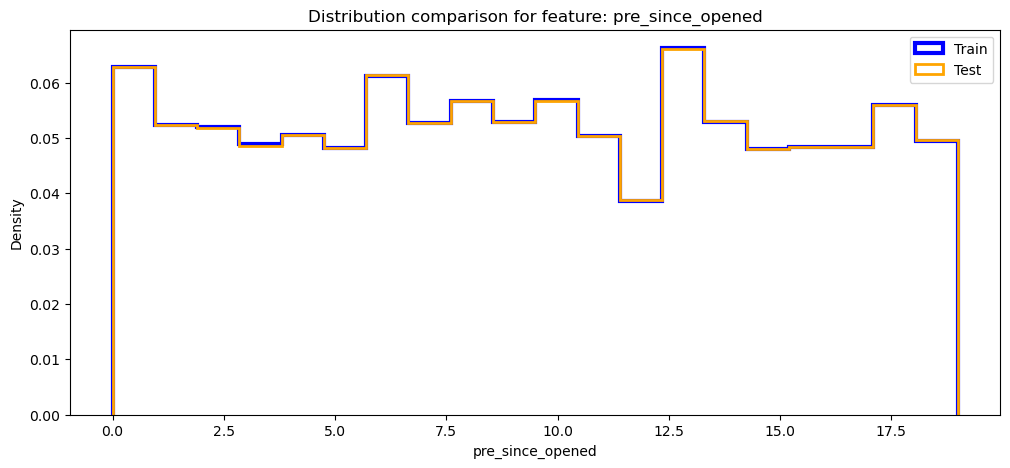

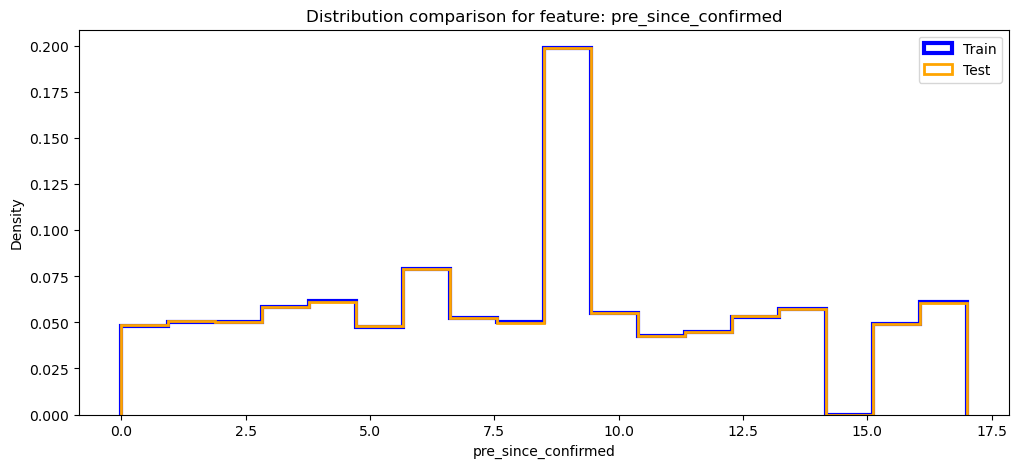

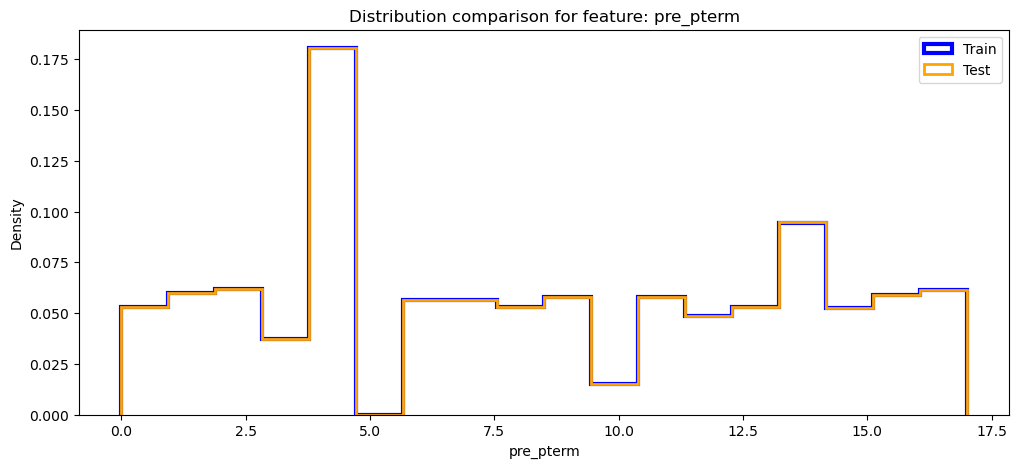

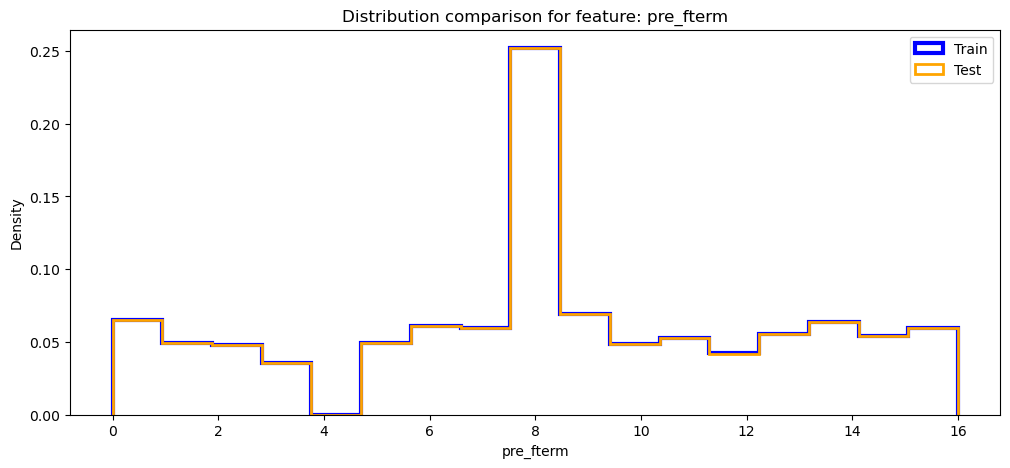

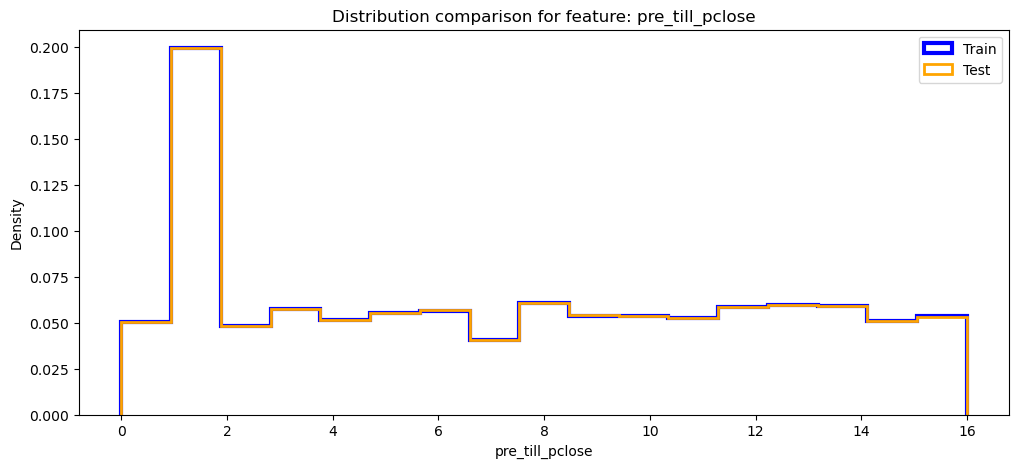

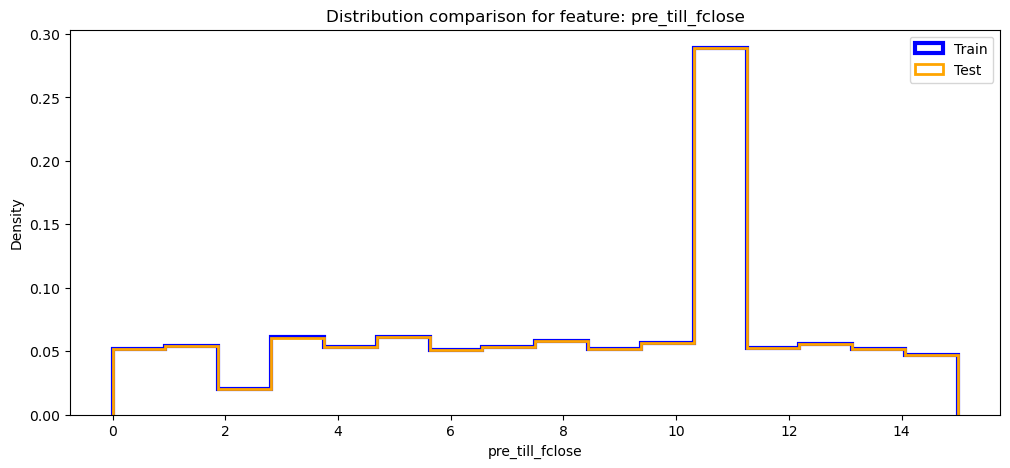

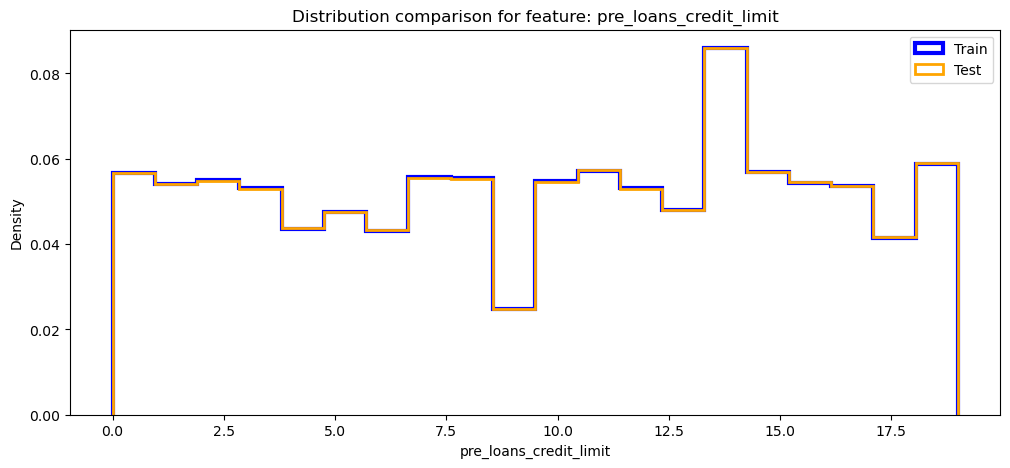

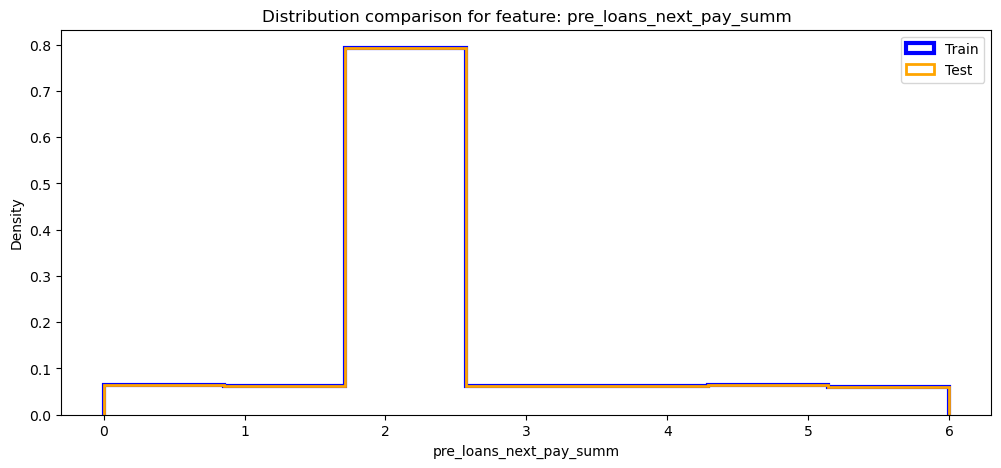

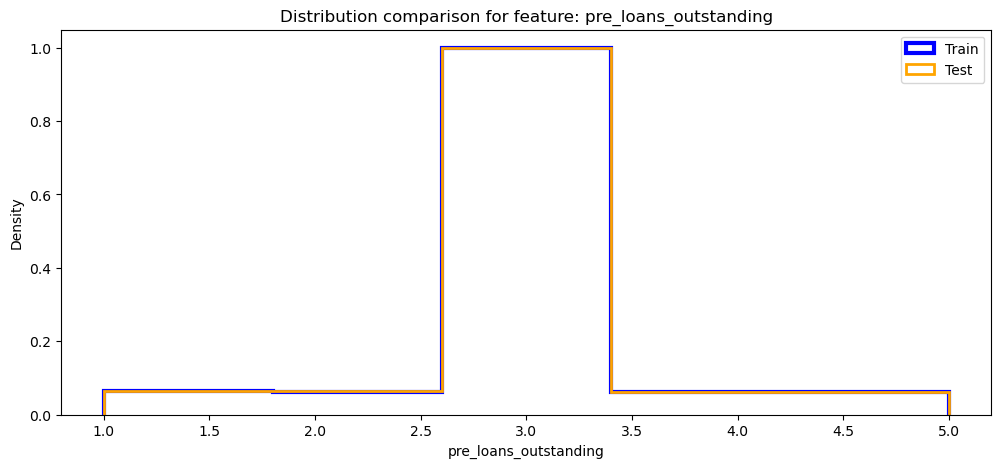

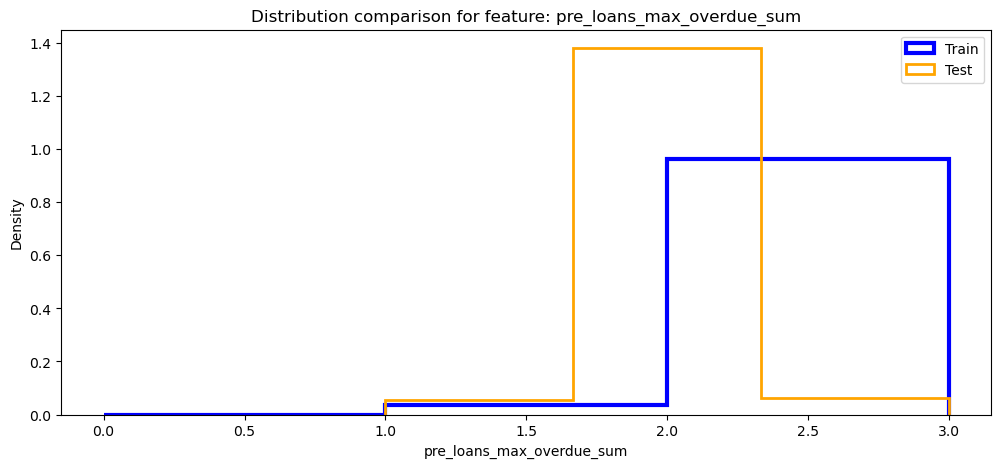

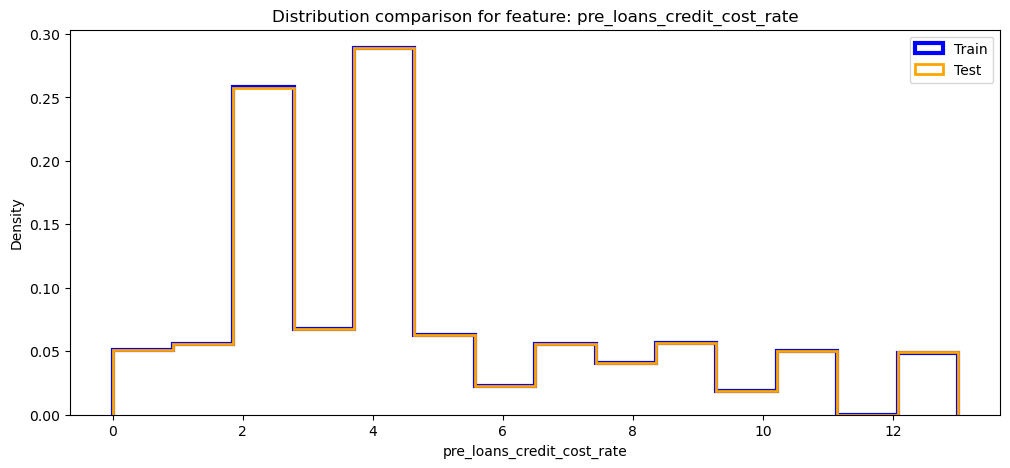

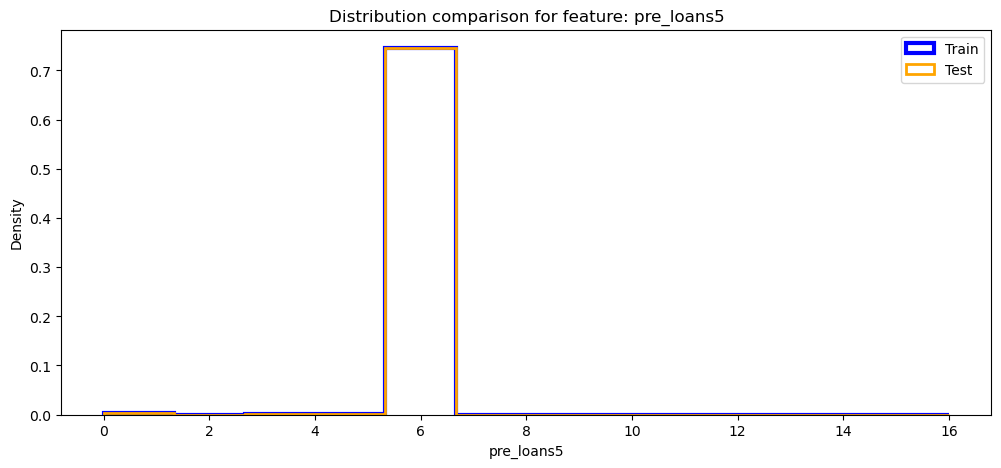

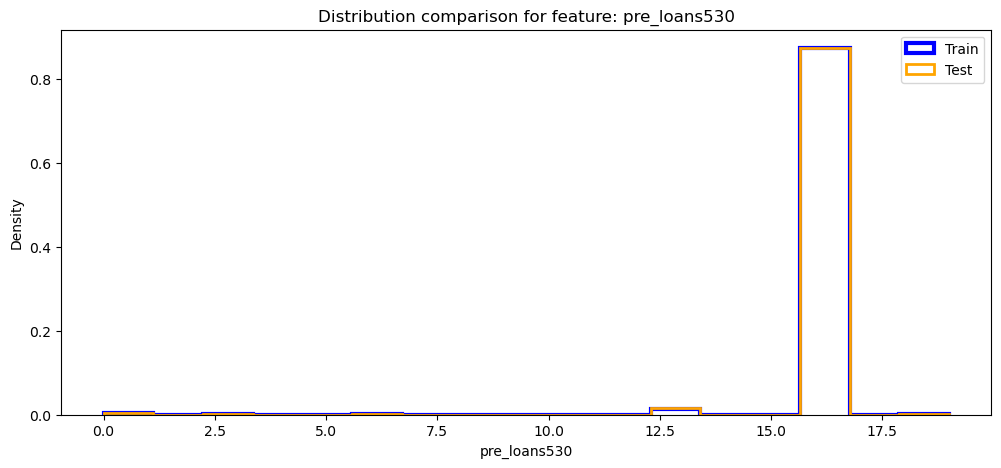

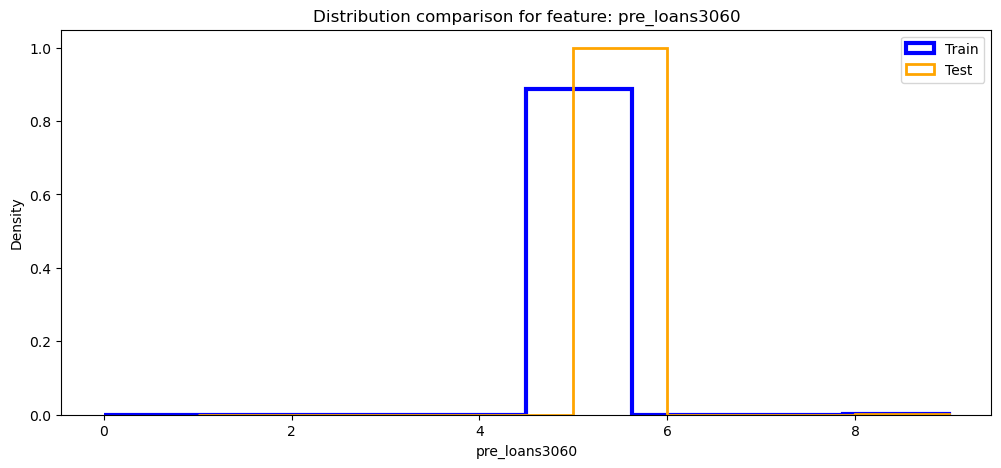

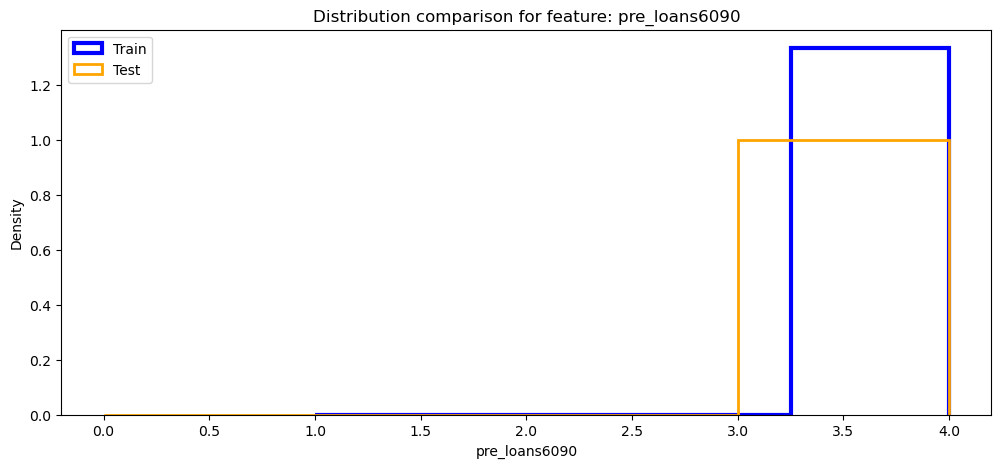

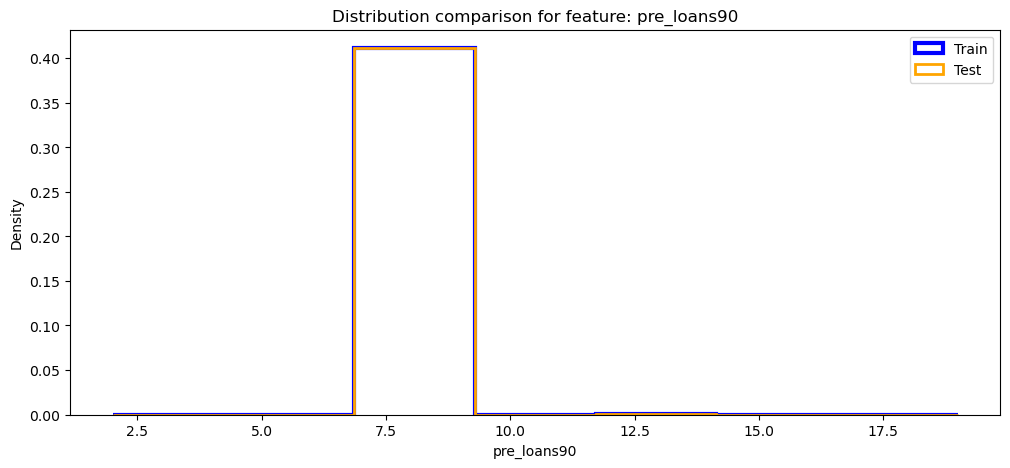

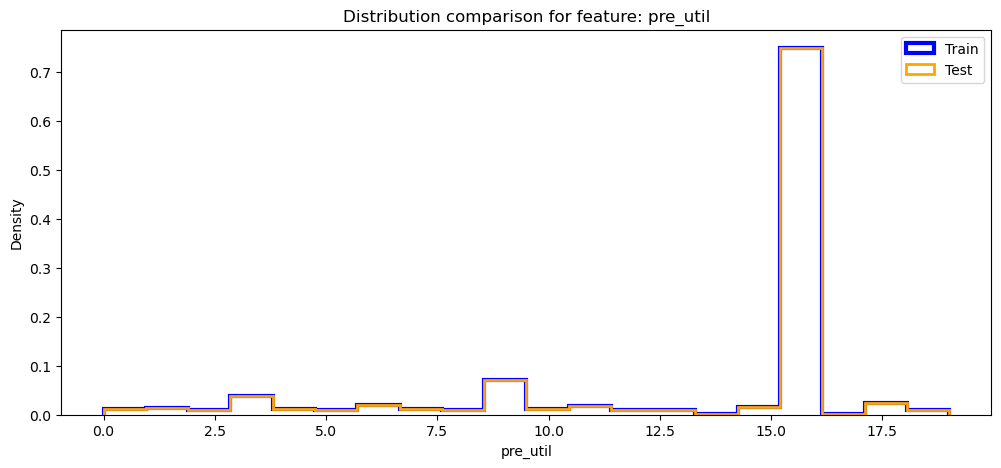

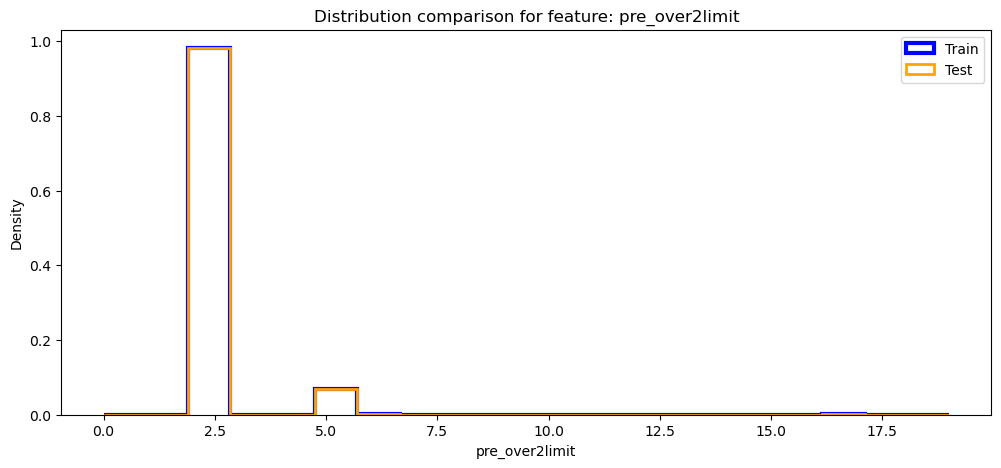

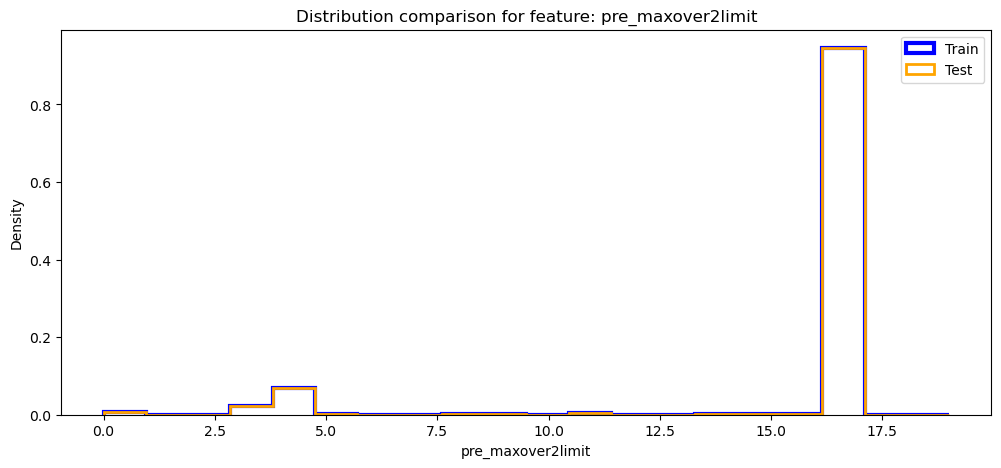

In [84]:
# Визуально сравним распределения признаков для тренировочного и тестового датасетов

for col in pre_features:
    plt.figure(figsize=(12, 5))
    
    # Объединяем значения признака из train и test для определения общего числа уникальных значений
    combined = np.concatenate([source_df_train[col], source_df_test[col]])
    
    # Выбираем количество бинов как минимальное число уникальных значений в train и test
    bins = min(source_df_train[col].nunique(), source_df_test[col].nunique())
    
    # Строим нормализованные гистограммы для тренировочного и тестового наборов
    plt.hist(
        source_df_train[col],
        bins=bins,
        density=True,
        label='Train',
        color='blue',
        histtype='step',
        linewidth=3
    )
    plt.hist(
        source_df_test[col],
        bins=bins,
        density=True,
        label='Test',
        color='orange',
        histtype='step',
        linewidth=2
    )

    plt.title(f'Distribution comparison for feature: {col}')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

Распределения признаков за некоторыми исключениями практически совпадают, что свидетельствует о корректном разбиении данных и отсутствии явного сдвига между выборками.    
Для  признаков  pre_loans_max_overdue_sum, pre_loans3060, pre_loans6090  различия распределений  между train и test связаны со слегка отличающимися наборами уникальных данных.

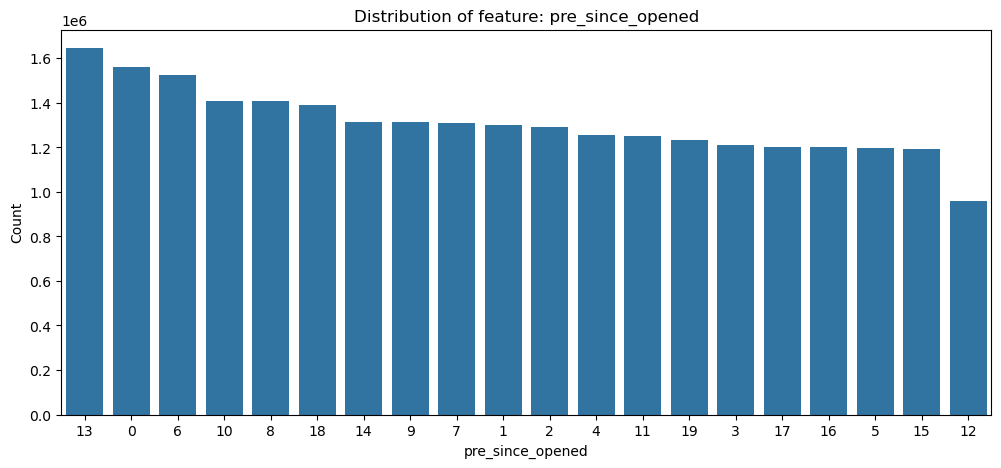

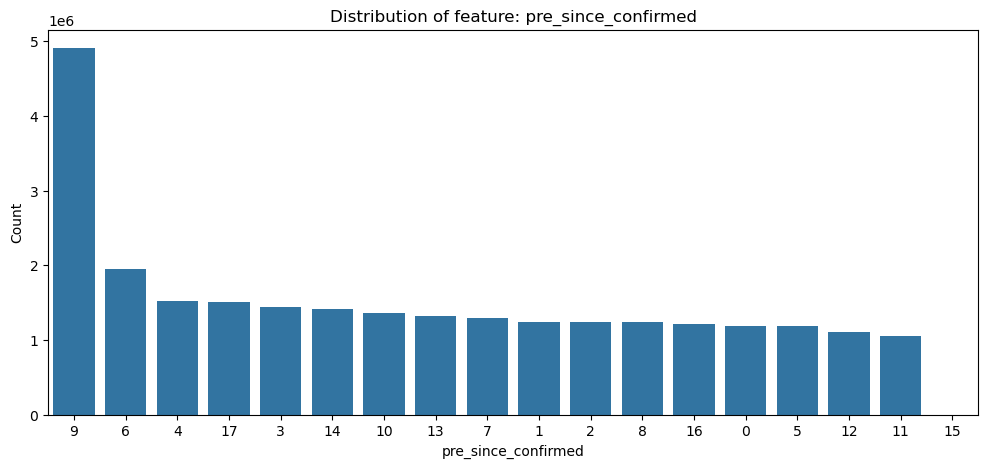

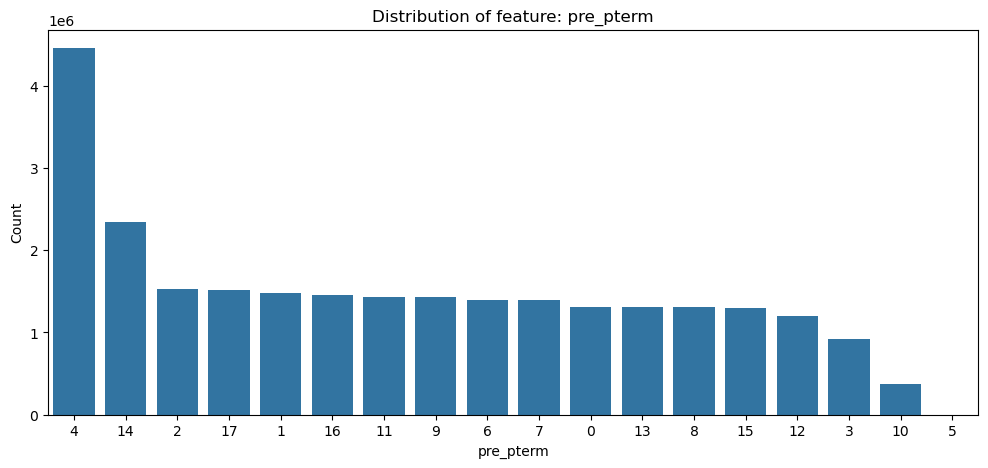

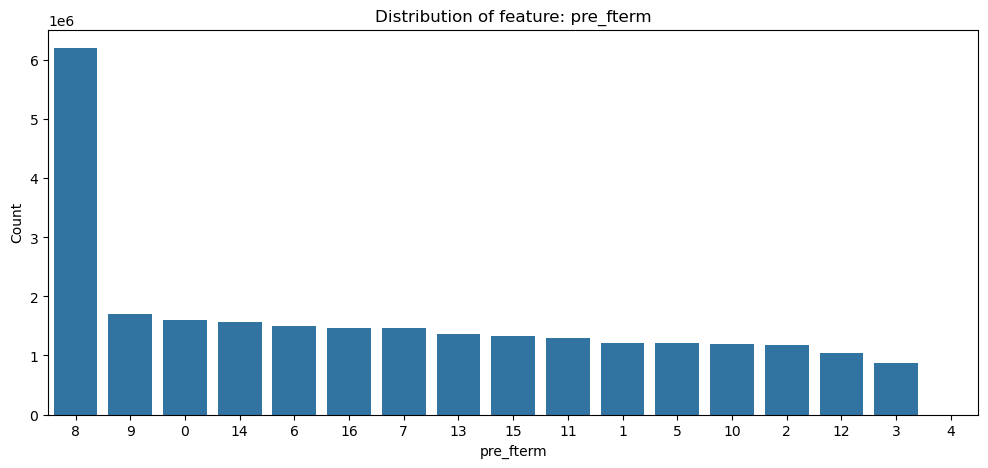

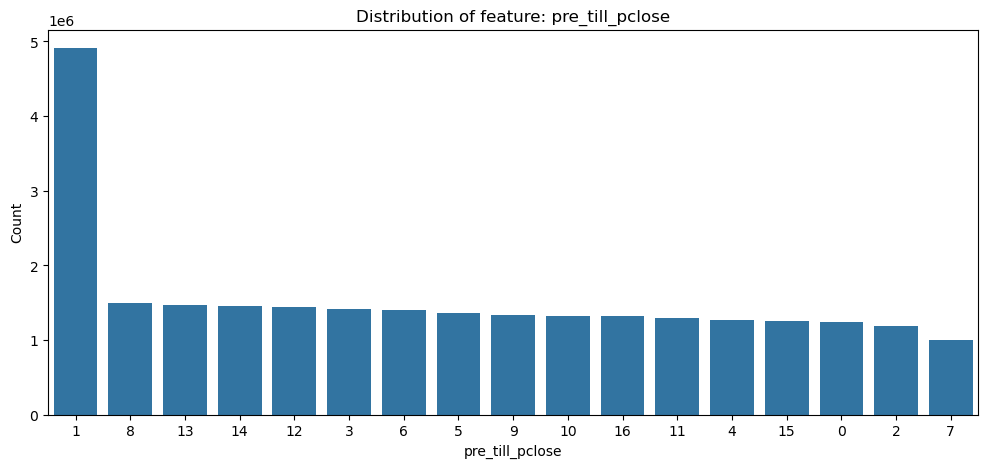

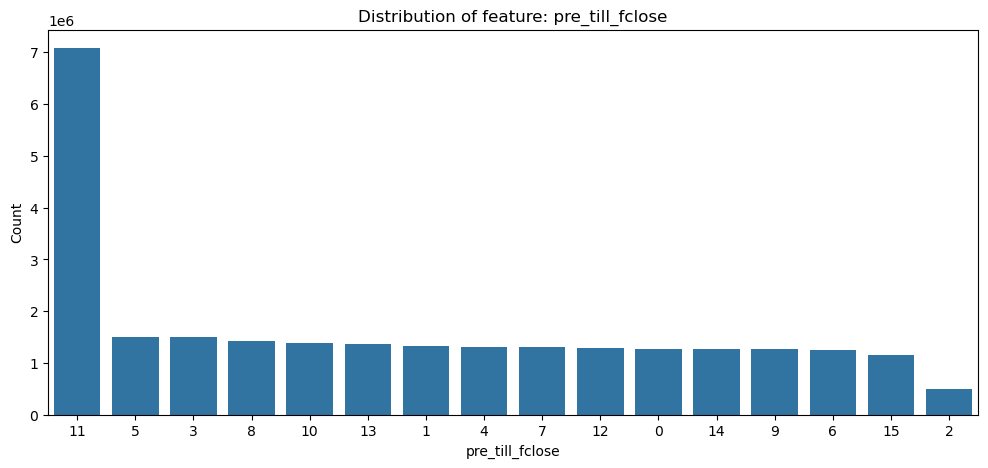

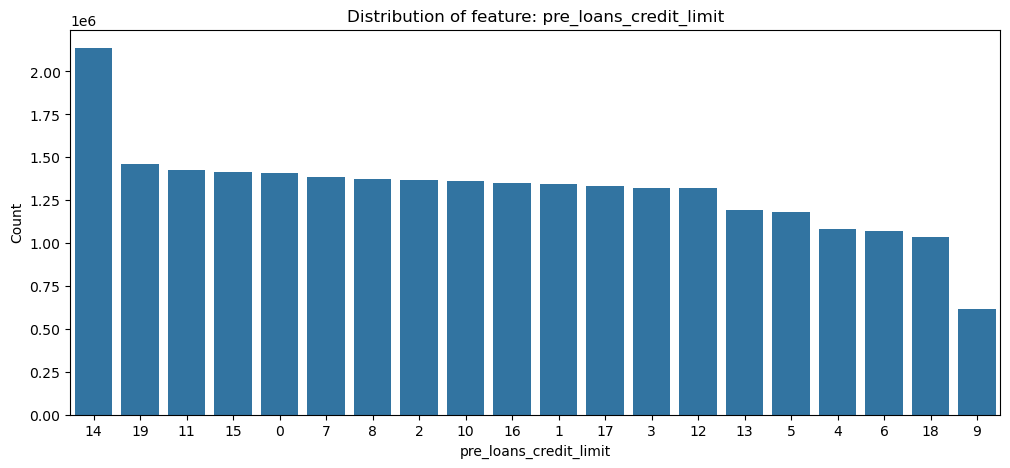

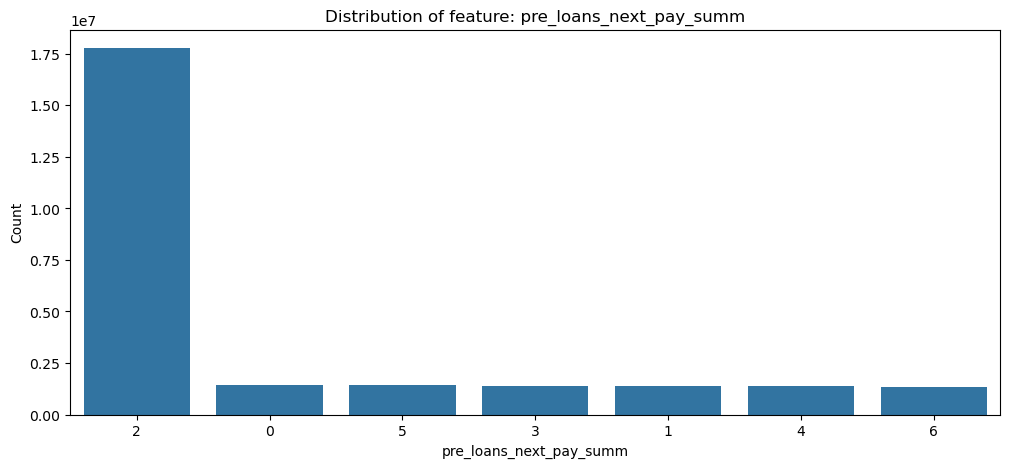

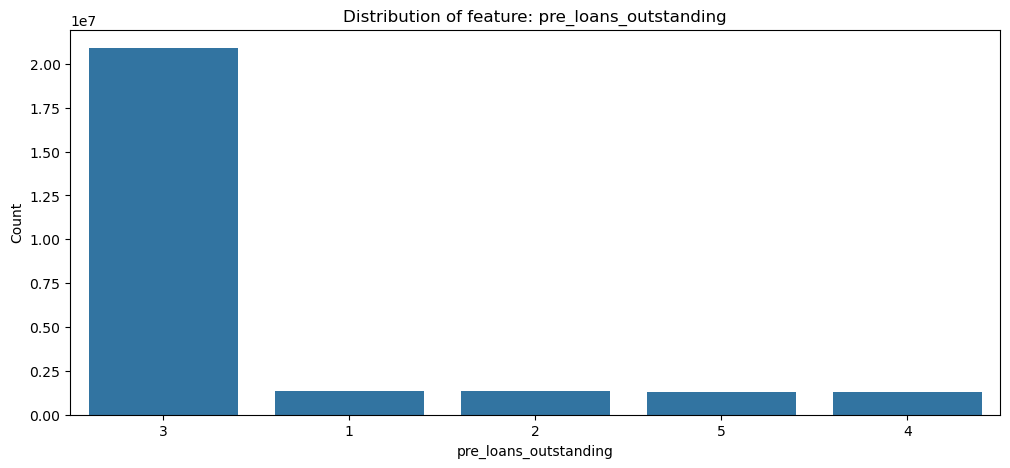

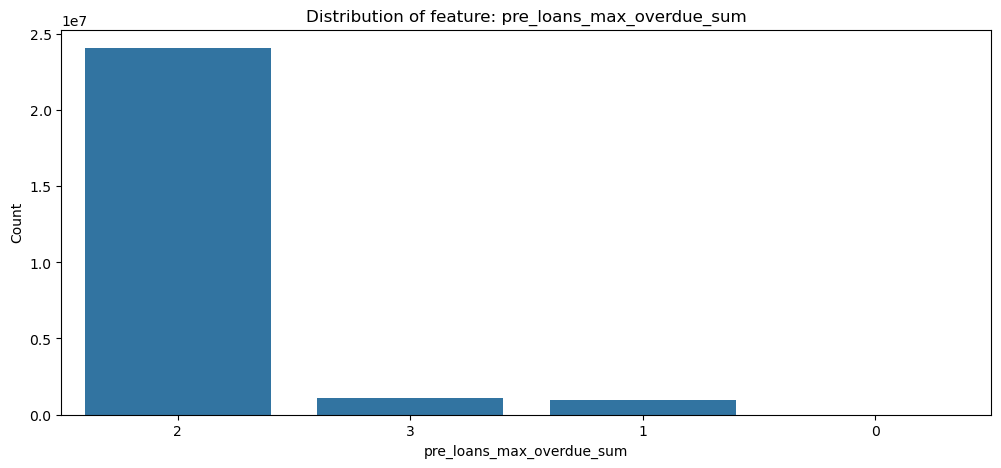

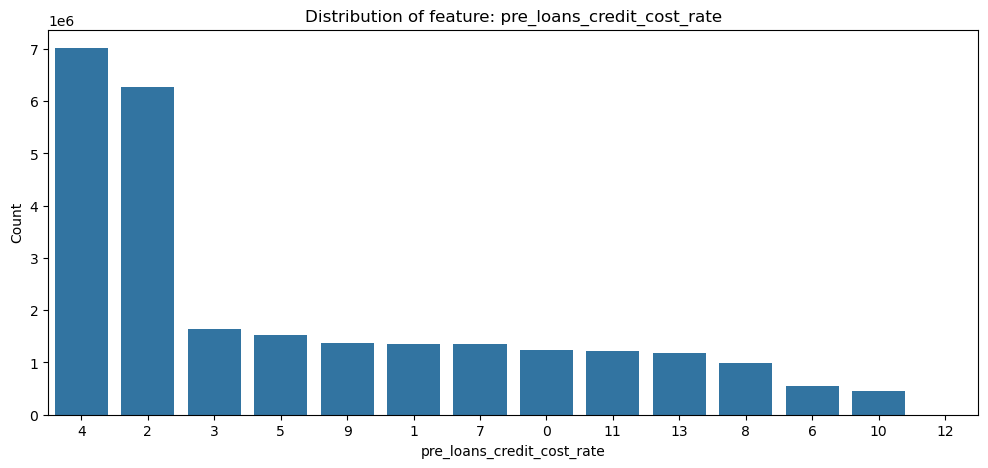

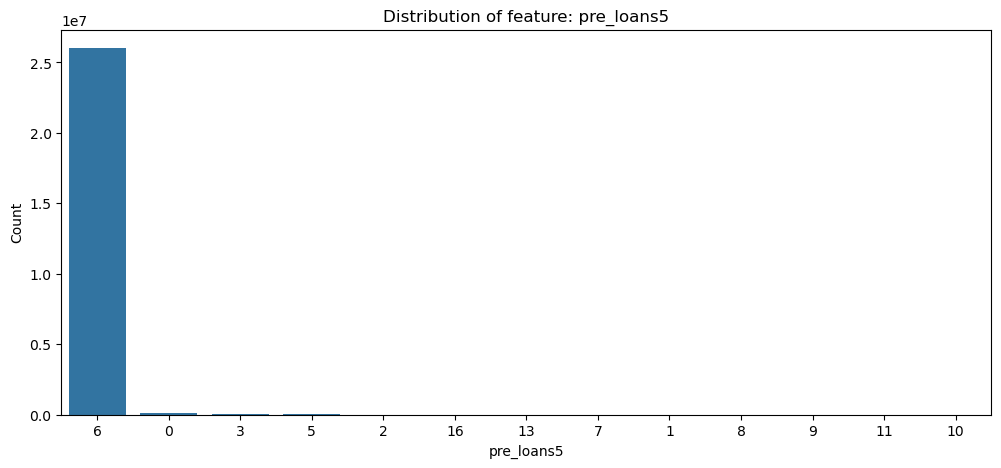

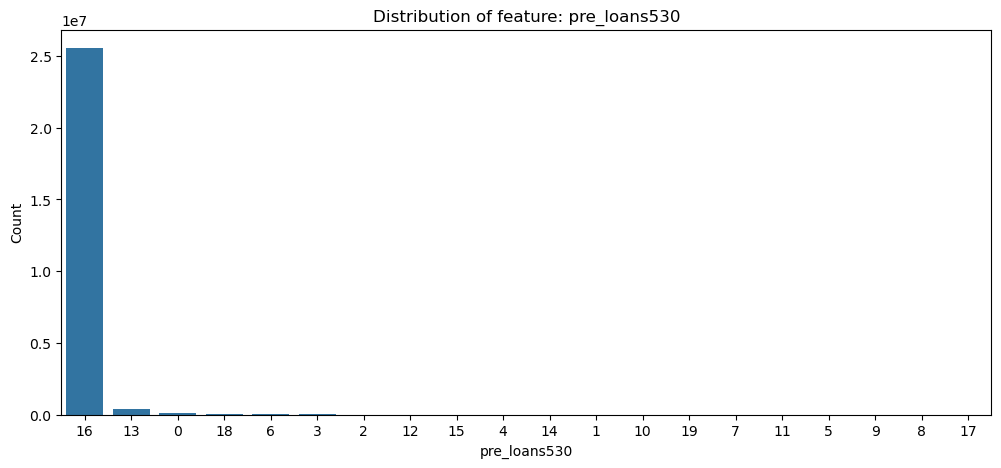

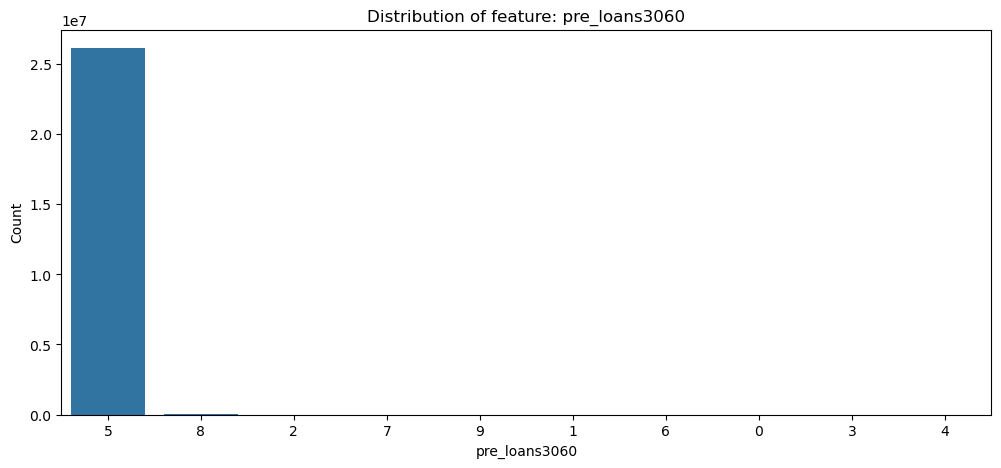

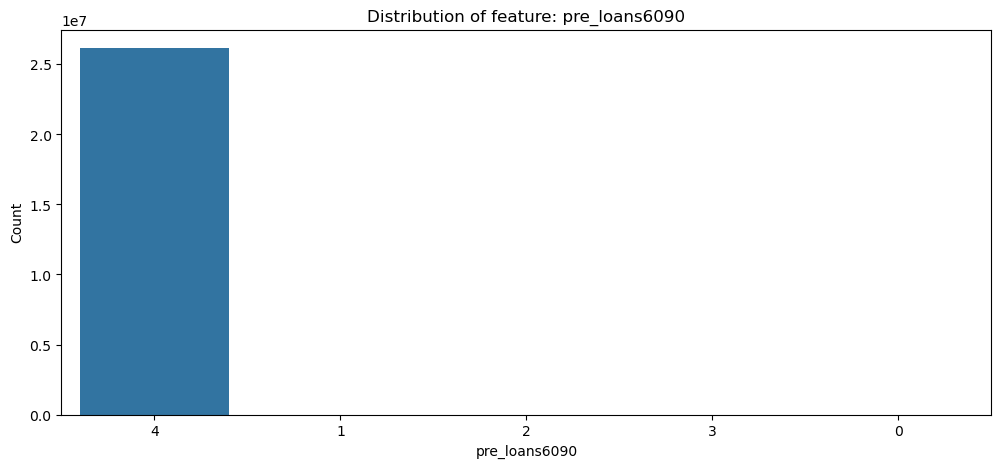

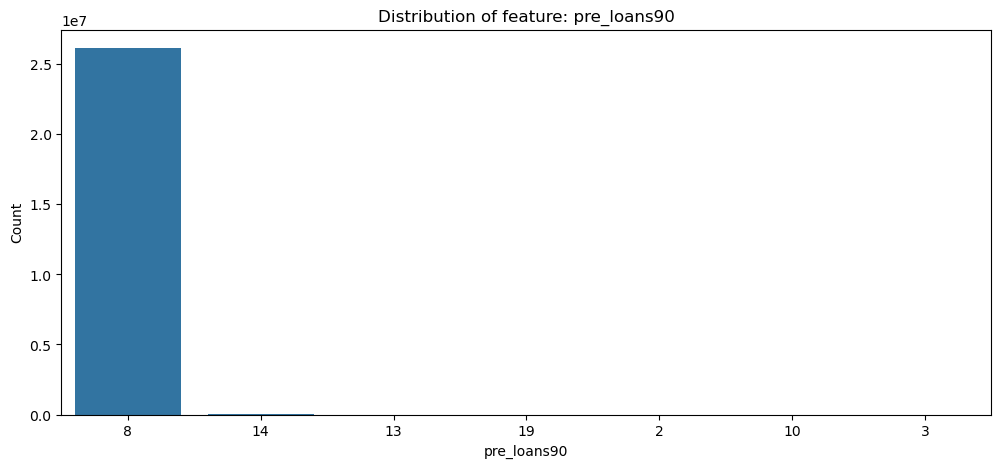

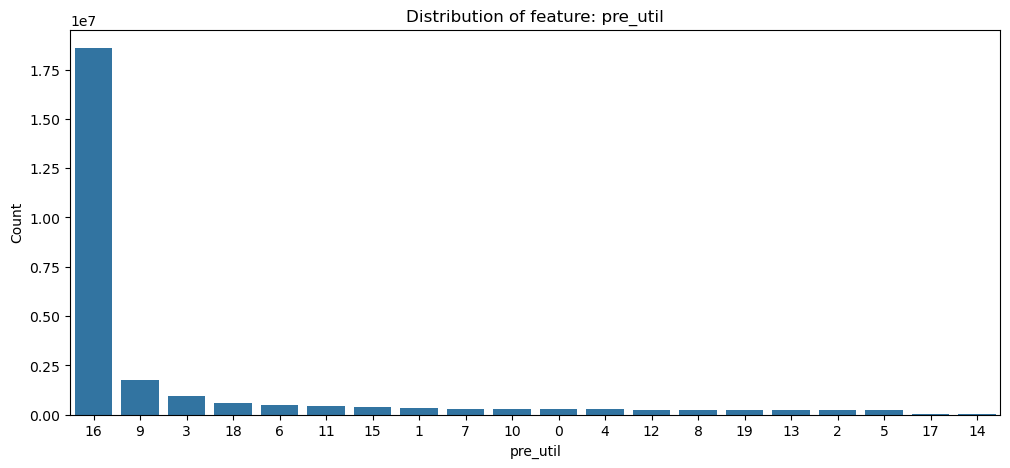

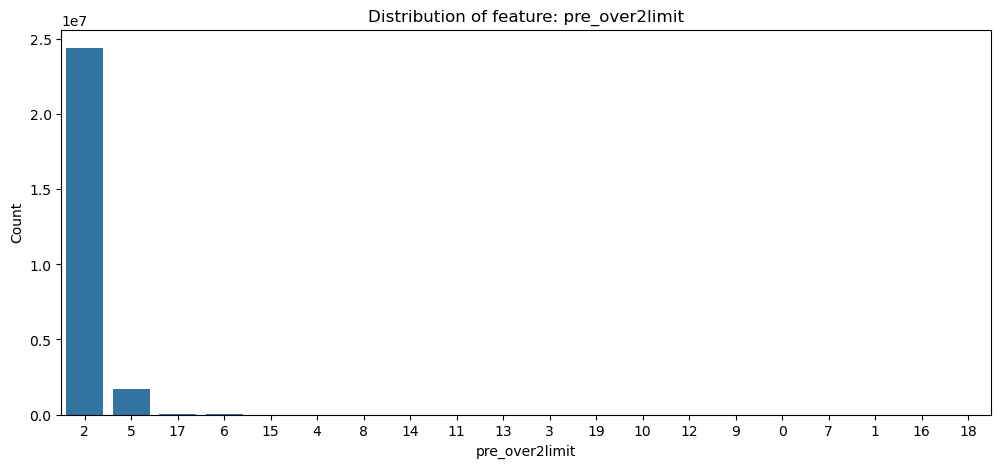

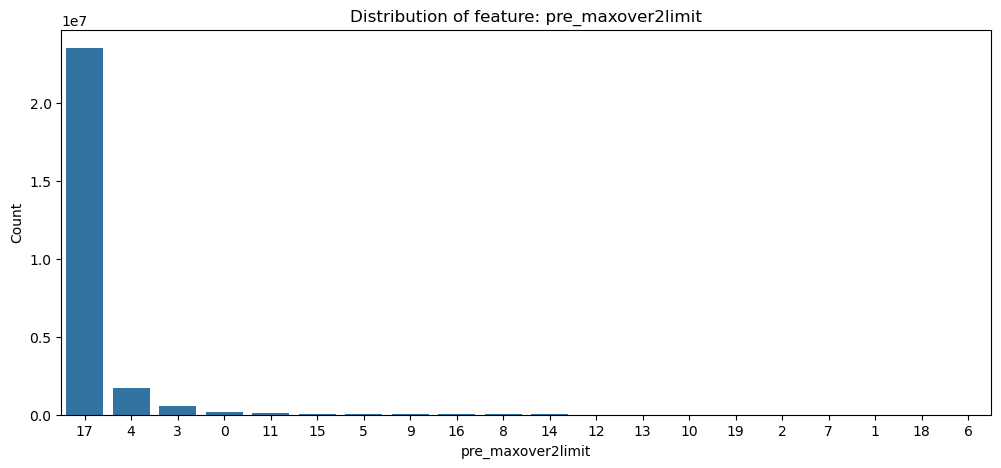

In [85]:
# Посмотрим на формы распределений признаков
for col in df[pre_features]:
    # Получаем частотности значений признака
    val_counts = df[col].value_counts()
    
    plt.figure(figsize=(12, 5))
    
    # Строим столбчатую диаграмму с порядком значений по убыванию частотности
    sns.barplot(
        x=val_counts.index,
        y=val_counts.values,
        order=val_counts.index
    )
    
    plt.title(f'Distribution of feature: {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()

Распределения по большинству признаков сильно смещены: для многих из них наблюдается выраженное преобладание одного или нескольких значений, тогда как остальные встречаются значительно реже. Это говорит о наличии дисбаланса и специфических частотных свойств в данных, что, вероятно, соответствует дисбалансу таргета.

Бинаризация сильно искажает информацию о реальных значениях признаков: после неё нельзя утверждать, что большее значение бинаризованного признака соответствует большему количеству исходного или наоборот. При бинаризации теряется количественная информация, и признаки становятся лишь индикаторами попадания в некий общий интервал исходного признака.    
Поэтому для дальнейшей работы будем опираться на частотные свойства значений признаков.